 Project

By Miguel Polanco

# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

  Using cached scikit_learn-1.3.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'INSTALLER'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1427,0,33.0,49800.0,1,0
2146,1,42.0,32400.0,0,1
2334,1,28.0,39800.0,2,0
593,1,20.0,37900.0,0,0
2511,1,53.0,47100.0,0,2
3462,0,35.0,26100.0,2,0
766,1,29.0,51500.0,5,0
1627,1,41.0,34300.0,2,0
4368,0,56.0,50300.0,2,3
3990,0,31.0,48400.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical
df['age'] = df['age'].astype('int32')
# write your conversion here if you choose:

In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int32  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


In [9]:
# now have a look at the data's descriptive statistics. 
df.describe()
# Does everything look okay?

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [10]:
# check missing values
df.isna().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

In [11]:
df = df.drop_duplicates().reset_index()

In [12]:
df.shape

(4847, 6)

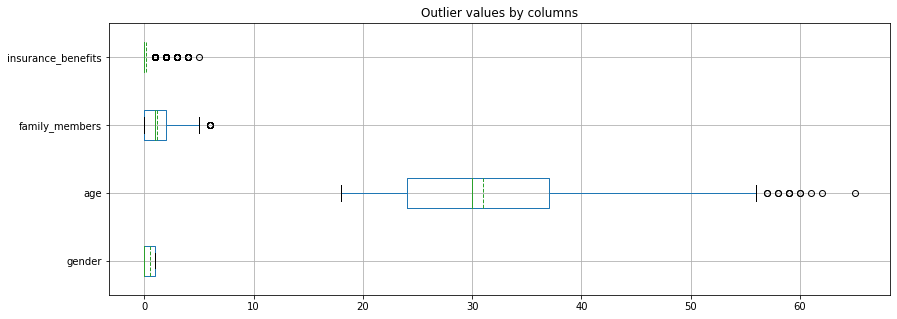

In [13]:
df.drop(['index','income'], axis=1).plot(kind='box', vert=False,figsize=(14,5), showmeans=True, meanline=True,grid=True)
plt.title( 'Outlier values by columns' )
plt.show()

In [14]:
# function for remove outlier by 3 sigma rule
def r_outlier(df, column):
    iqr = np.percentile(df[column], 75) - np.percentile(df[column], 25)
    # Remove outliers
    return df[(df[column] >= np.percentile(df[column], 25) - 1.5 * iqr) &
            (df[column] <= np.percentile(df[column], 75) + 1.5 * iqr)]

In [15]:
# Calculate the IQR
iqr = np.percentile(df['age'], 75) - np.percentile(df['age'], 25)

# Remove outliers
df = df[(df['age'] >= np.percentile(df['age'], 25) - 1.5 * iqr) &
        (df['age'] <= np.percentile(df['age'], 75) + 1.5 * iqr)]

In [16]:
df = r_outlier(df,'age')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4835 entries, 0 to 4846
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               4835 non-null   int64  
 1   gender              4835 non-null   int64  
 2   age                 4835 non-null   int32  
 3   income              4835 non-null   float64
 4   family_members      4835 non-null   int64  
 5   insurance_benefits  4835 non-null   int64  
dtypes: float64(1), int32(1), int64(4)
memory usage: 245.5 KB


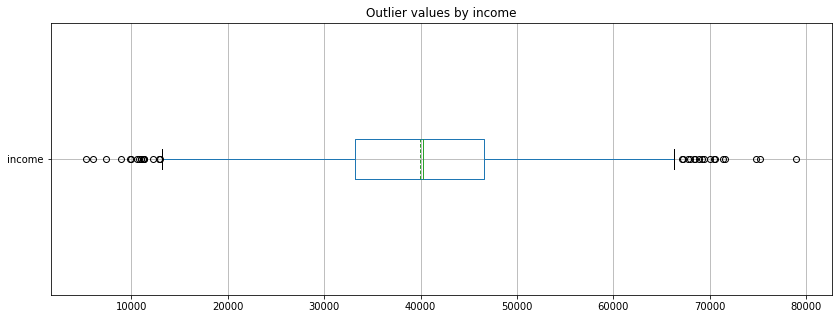

In [17]:
df['income'].plot(kind='box', vert=False, showmeans=True, meanline=True,figsize=(14,5),grid=True)
plt.title( 'Outlier values by income' )
plt.show()

In [18]:
df = r_outlier(df,'income')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 0 to 4846
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               4801 non-null   int64  
 1   gender              4801 non-null   int64  
 2   age                 4801 non-null   int32  
 3   income              4801 non-null   float64
 4   family_members      4801 non-null   int64  
 5   insurance_benefits  4801 non-null   int64  
dtypes: float64(1), int32(1), int64(4)
memory usage: 243.8 KB


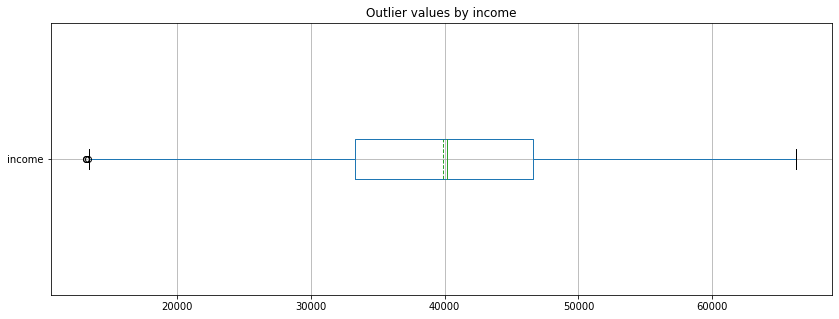

In [19]:
df['income'].plot(kind='box', vert=False, showmeans=True, meanline=True,figsize=(14,5),grid=True)
plt.title( 'Outlier values by income' )
plt.show()

Gender in dataset is presented with the aid of number 1 or zero, more than 75% of customers didn't get any coverage advantage, information is provided for customers elderly 18 to sixty five.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice exploration of the data!

</div>

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

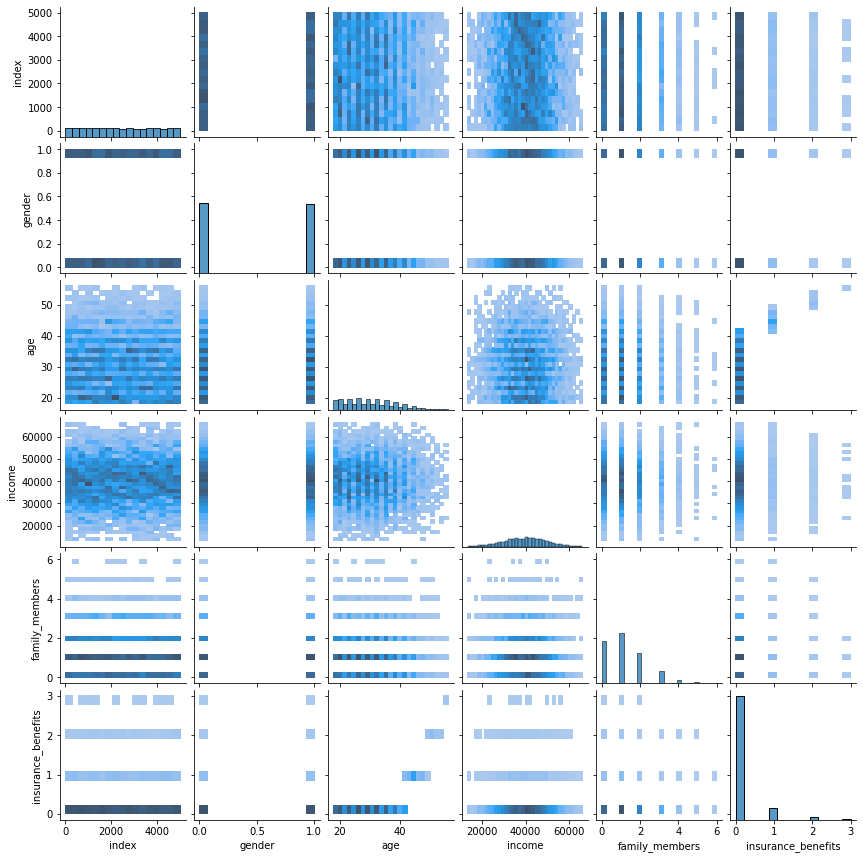

In [20]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

In [21]:
df.corr()

,index,gender,age,income,family_members,insurance_benefits
index,1.000000,-0.003023,-0.000122,0.004145,-0.001565,0.007224
gender,-0.003023,1.000000,0.000193,0.009036,-0.005441,0.007223
age,-0.000122,0.000193,1.000000,-0.012872,-0.007036,0.649558
income,0.004145,0.009036,-0.012872,1.000000,-0.026319,-0.003658
family_members,-0.001565,-0.005441,-0.007036,-0.026319,1.000000,-0.035723
insurance_benefits,0.007224,0.007223,0.649558,-0.003658,-0.035723,1.000000


column age and Insurance benefits are close correlation

1) The details of insurance members, including gender, age, income, family benefits, and insurance benefits they receive, are described in each observation.

2) The distribution of age is skewed to the right, while the distribution of income seems to follow a normal distribution.

3) No missing values are present in the data.

4) A total of 153 (3%) duplicates have been identified.

5) A significant positive correlation exists between the age of insured individuals and the insurance benefits they receive.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Interesting observations!

</div>

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [22]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [23]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors = k, metric = metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

<div class="alert alert-success">
<b>Reviewer's comment</b>

The function for finding nearest neighbors is correct

</div>

Scaling the data.

In [24]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [25]:
df_scaled.sample(5)

,index,gender,age,income,family_members,insurance_benefits
2439,2483,1.0,0.589286,0.799397,0.166667,0
585,588,0.0,0.660714,0.511312,0.333333,0
2997,3066,0.0,0.375000,0.690799,0.500000,0
1653,1675,0.0,0.392857,0.739065,0.500000,0
4824,4977,1.0,0.732143,0.598793,0.000000,0


Now, let's get similar records for a given one for every combination

In [26]:
df = df.reset_index(drop=True)
df_scaled = df_scaled.reset_index(drop=True)

without scaling df - euclidean

In [27]:
get_knn(df,5,20,'euclidean')

,index,gender,age,income,family_members,insurance_benefits,distance
5,5,1,43,41000.0,2,1,0.000000
1951,1995,0,45,41000.0,0,1,3.000000
3825,3972,1,40,41000.0,1,0,3.162278
4571,4763,1,46,41000.0,1,1,3.162278
3661,3801,0,46,41000.0,2,1,3.162278
2680,2759,0,47,41000.0,3,1,4.242641
2639,2717,0,37,41000.0,0,0,6.403124
3312,3434,1,36,41000.0,2,0,7.000000
1703,1740,0,36,41000.0,1,0,7.141428
2792,2876,0,35,41000.0,2,0,8.062258


without scaling dataframe manhattan

In [28]:
get_knn(df, 5, 20, 'manhattan')

,index,gender,age,income,family_members,insurance_benefits,distance
5,5,1,43,41000.0,2,1,0.0
3661,3801,0,46,41000.0,2,1,4.0
3825,3972,1,40,41000.0,1,0,4.0
4571,4763,1,46,41000.0,1,1,4.0
1951,1995,0,45,41000.0,0,1,5.0
2680,2759,0,47,41000.0,3,1,6.0
3312,3434,1,36,41000.0,2,0,7.0
2639,2717,0,37,41000.0,0,0,9.0
2792,2876,0,35,41000.0,2,0,9.0
1703,1740,0,36,41000.0,1,0,9.0


Scaling dataframe euclidean

In [29]:
get_knn(df_scaled, 5, 20, 'euclidean')

,index,gender,age,income,family_members,insurance_benefits,distance
5,5,1.0,0.767857,0.618401,0.333333,1,0.000000
1127,1147,1.0,0.750000,0.615385,0.333333,0,0.018110
3918,4074,1.0,0.767857,0.597285,0.333333,1,0.021116
1004,1019,1.0,0.750000,0.597285,0.333333,0,0.027654
2877,2962,1.0,0.732143,0.619910,0.333333,0,0.035746
2082,2128,1.0,0.803571,0.610860,0.333333,1,0.036502
105,106,1.0,0.803571,0.627451,0.333333,1,0.036843
2156,2206,1.0,0.803571,0.631976,0.333333,1,0.038207
2295,2352,1.0,0.803571,0.633484,0.333333,1,0.038769
709,719,1.0,0.732143,0.634992,0.333333,0,0.039380


Scaling dataframe manhattan

In [30]:
get_knn(df_scaled, 5, 20, 'manhattan')

,index,gender,age,income,family_members,insurance_benefits,distance
5,5,1.0,0.767857,0.618401,0.333333,1,0.000000
1127,1147,1.0,0.750000,0.615385,0.333333,0,0.020874
3918,4074,1.0,0.767857,0.597285,0.333333,1,0.021116
2877,2962,1.0,0.732143,0.619910,0.333333,0,0.037223
1004,1019,1.0,0.750000,0.597285,0.333333,0,0.038973
2082,2128,1.0,0.803571,0.610860,0.333333,1,0.043256
105,106,1.0,0.803571,0.627451,0.333333,1,0.044764
2156,2206,1.0,0.803571,0.631976,0.333333,1,0.049289
2295,2352,1.0,0.803571,0.633484,0.333333,1,0.050797
709,719,1.0,0.732143,0.634992,0.333333,0,0.052306


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

When analyzing unscaled data, the algorithm identifies customers who have the same income, whereas with scaled data, it identifies customers who have the same number of family members.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

By comparing unscaled and scaled data, we obtain entirely disparate outcomes.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright!

</div>

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [31]:
# calculate the target

df['insurance_benefits_received'] = np.where(df_scaled['insurance_benefits'] == 0,0,1)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Target is calculated correctly

</div>

In [32]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0    4254
1     547
Name: insurance_benefits_received, dtype: int64

In [33]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [34]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [35]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8860654 0.       ]
 [0.1139346 0.       ]]

The probability: 0.11
F1: 0.10
Confusion Matrix
[[0.78504478 0.10102062]
 [0.10247865 0.01145595]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.45053114 0.43553426]
 [0.05707144 0.05686315]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.        0.8860654]
 [0.        0.1139346]]



In case of dummy model that returns 1 with probability 0 we get correct answer in 88,7% of cases but F1 score is 0. 
In case of dummy model that returns 1 with probability 0.11 (actual probability that a customer will receive a benifit) we get correct answer in 79% of cases and F1 score is 0.12. 
In case of dummy model that returns 1 with probability 0.5 we get correct answer in 45,6% of cases with F1 score 0.20. 
In case of dummy model that returns 1 with probability 1 we get correct answer in 88,7% of cases and F1 score is 0.20.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Right!

</div>

In [36]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits_received'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [37]:
for neigh in range(1,11):
    model = KNeighborsClassifier(n_neighbors= neigh)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Results for {} neighbors'.format(neigh))
    eval_classifier(y_test, y_pred)
    print('___________________')

Results for 1 neighbors
F1: 0.60
Confusion Matrix
[[0.87578071 0.01318529]
 [0.05759889 0.05343511]]
___________________
Results for 2 neighbors
F1: 0.36
Confusion Matrix
[[0.88549618 0.00346981]
 [0.08605135 0.02498265]]
___________________
Results for 3 neighbors
F1: 0.36
Confusion Matrix
[[0.87508675 0.01387925]
 [0.0832755  0.0277585 ]]
___________________
Results for 4 neighbors
F1: 0.11
Confusion Matrix
[[0.88272033 0.00624566]
 [0.10409438 0.00693963]]
___________________
Results for 5 neighbors
F1: 0.12
Confusion Matrix
[[0.88133241 0.00763359]
 [0.10340042 0.00763359]]
___________________
Results for 6 neighbors
F1: 0.06
Confusion Matrix
[[0.88757807 0.00138793]
 [0.10756419 0.00346981]]
___________________
Results for 7 neighbors
F1: 0.07
Confusion Matrix
[[0.88549618 0.00346981]
 [0.10687023 0.00416378]]
___________________
Results for 8 neighbors
F1: 0.05
Confusion Matrix
[[0.888966   0.        ]
 [0.10825815 0.00277585]]
___________________
Results for 9 neighbors
F1: 0.07

In case of unscaled data we get the best F1 score in case of 1 neighbor, the highest accuracy reached in case of 3 neighbors.

In [38]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits_received'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)


transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(X_train)

X_train = transformer_mas.transform(X_train)
X_test = transformer_mas.transform(X_test)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Scaling was applied correctly!
    

</div>

In [39]:
for neigh in range(1,11):
    model = KNeighborsClassifier(n_neighbors= neigh)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Results for {} neighbors'.format(neigh))
    eval_classifier(y_test, y_pred)
    print('___________________')

Results for 1 neighbors
F1: 0.94
Confusion Matrix
[[0.88688411 0.00208189]
 [0.00971548 0.10131853]]
___________________
Results for 2 neighbors
F1: 0.91
Confusion Matrix
[[0.888966   0.        ]
 [0.01873699 0.09229702]]
___________________
Results for 3 neighbors
F1: 0.92
Confusion Matrix
[[0.8834143  0.0055517 ]
 [0.01249133 0.09854268]]
___________________
Results for 4 neighbors
F1: 0.92
Confusion Matrix
[[0.888966  0.       ]
 [0.0166551 0.0943789]]
___________________
Results for 5 neighbors
F1: 0.91
Confusion Matrix
[[0.88480222 0.00416378]
 [0.01457321 0.09646079]]
___________________
Results for 6 neighbors
F1: 0.89
Confusion Matrix
[[0.88688411 0.00208189]
 [0.02012491 0.09090909]]
___________________
Results for 7 neighbors
F1: 0.90
Confusion Matrix
[[0.88480222 0.00416378]
 [0.0166551  0.0943789 ]]
___________________
Results for 8 neighbors
F1: 0.87
Confusion Matrix
[[8.88272033e-01 6.93962526e-04]
 [2.49826509e-02 8.60513532e-02]]
___________________
Results for 9 neighb

The F1 score is found to be optimal when using 1 neighbor for scaled data, while the highest accuracy is achieved with 3 neighbors. Scaled data exhibits superior performance in terms of both F1 score and accuracy.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you successfully applied kNN to a classification problem! 

</div>

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [40]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X),1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

<div class="alert alert-success">
<b>Reviewer's comment</b>

Linear regression was implemented correctly!

</div>

In [41]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [42]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-8.74929647e-01  3.40639787e-02 -5.48116139e-05 -3.94300683e-07
 -1.58537033e-02]
RMSE: 0.32
R2: 0.65


After training the model on unscaled data we got RMSE 0.34 and R2 score 0.66

In [43]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)


transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(X_train)

X_train = transformer_mas.transform(X_train)
X_test = transformer_mas.transform(X_test)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-8.74929647e-01  1.90758281e+00 -5.48116139e-05 -2.60632752e-02
 -9.51222198e-02]
RMSE: 0.32
R2: 0.65


The linear regression algorithm remains unaffected by data scaling, as evidenced by the RMSE of 0.32 and R2 score of 0.65 obtained after training the model on unscaled data.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Indeed!

</div>

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [44]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [45]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [46]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [47]:
print(np.linalg.det(P))

0.24339135998015463


Can you guess the customers' ages or income after the transformation?

In [48]:
X_ob = X@P

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [49]:
X_rec = np.dot(X_ob, np.linalg.inv(P))

<div class="alert alert-success">
<b>Reviewer's comment</b>

Correct!

</div>

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [50]:
print('The original data\n',X[1],'\n', X[2])

The original data
 [0.0e+00 4.6e+01 3.8e+04 1.0e+00] 
 [    0.    29. 21000.     0.]


In [51]:
print('The transformed one\n',X_ob[1],'\n', X_ob[2])

The transformed one
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301] 
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]


In [52]:
print('The reversed (recovered) one \n',X_rec[1],'\n', X_rec[2])

The reversed (recovered) one 
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00] 
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The reason is accuracy of calculus and rounding.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Pretty much!

</div>

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

$$ w_P = [(XP)^T XP]^{-1} (XP)^T y = (XP)^{-1} y = P^{-1} w \quad \Rightarrow \quad w_P = P^{-1}w $$

The predicted values remain the same because for every matrix A :

$$ Aw = (AP)w_P $$

Let's tell that

$$ X^T X = A $$



**Analytical proof**

So

$$ w_P = [(XP)^T XP]^{-1} (XP)^T y 
       = [P^T X^T XP]^{-1} (XP)^T y 
       = [P^T A P]^{-1} (XP)^T y 
       = P^{-1} A (P^T)^{-1} P^T X^T y 
       = P^{-1} A^{-1} X^T y 
       = P^{-1}(X^T X)^{-1} X^T y $$
       
As we know that

$$ w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = P^{-1}w $$

<div class="alert alert-success">
<b>Reviewer's comment</b>

The proof is correct, well done!

</div>

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [53]:
X = df_pn.to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-8.74929647e-01 -5.48116139e-05  3.40639787e-02 -3.94300683e-07
 -1.58537033e-02]
RMSE: 0.32
R2: 0.65


In [54]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
print (np.linalg.det(P))

0.24339135998015463


In [55]:
X_ob = X@P

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_ob, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.87492967 -0.06707495 -0.00365387  0.07894941 -0.02054006]
RMSE: 0.32
R2: 0.65


We have empirically examined the hypothesis that data obfuscation does not have any effect on the linear regression model through practical experimentation.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Well done!

</div>

# Conclusions

For the purposes of this project, the neighborhood search was conducted using the Manhattan distribution and the Euclidean distribution for both scaled and unpredicted data. The results for both metrics are the same when using the same source data. However, the results for unpredicted and scaled data are quite different.

The k-NN algorithm performs better when the data is scaled (i.e., 3 neighbors). If the data is not scaled, the k-NN algorithm does not perform as well as a dummy model.

Scaling of information would not have an effect on Linear Regression Algorithms. We prove why statistics obfuscation doesn't make an effect on predictions of Linear regression algorithms so would not affect RMSE and R2 score.


<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice summary!

</div>

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells are arranged in order of logic and execution
- [ ]  Task 1 has been performed
    - [ ]  There is the procedure that can return k similar customers for a given one
    - [ ]  The procedure is tested for all four proposed combinations
    - [ ]  The questions re the scaling/distances are answered
- [ ]  Task 2 has been performed
    - [ ]  The random classification model is built and tested for all for probability levels
    - [ ]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [ ]  Task 3 has been performed
    - [ ]  The linear tegression solution is implemented with matrix operations.
    - [ ]  RMSE is calculated for the implemented solution.
- [ ]  Task 4 has been performed
    - [ ]  The data is obfuscated with a random and invertible matrix P
    - [ ]  The obfuscated data is recoved, few examples are printed out
    - [ ]  The analytical proof that the transformation does not affect RMSE is provided 
    - [ ]  The computational proof that the transformation does not affect RMSE is provided
- [ ]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>